In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx

Mean Load: 50 ; Variance Load: 10


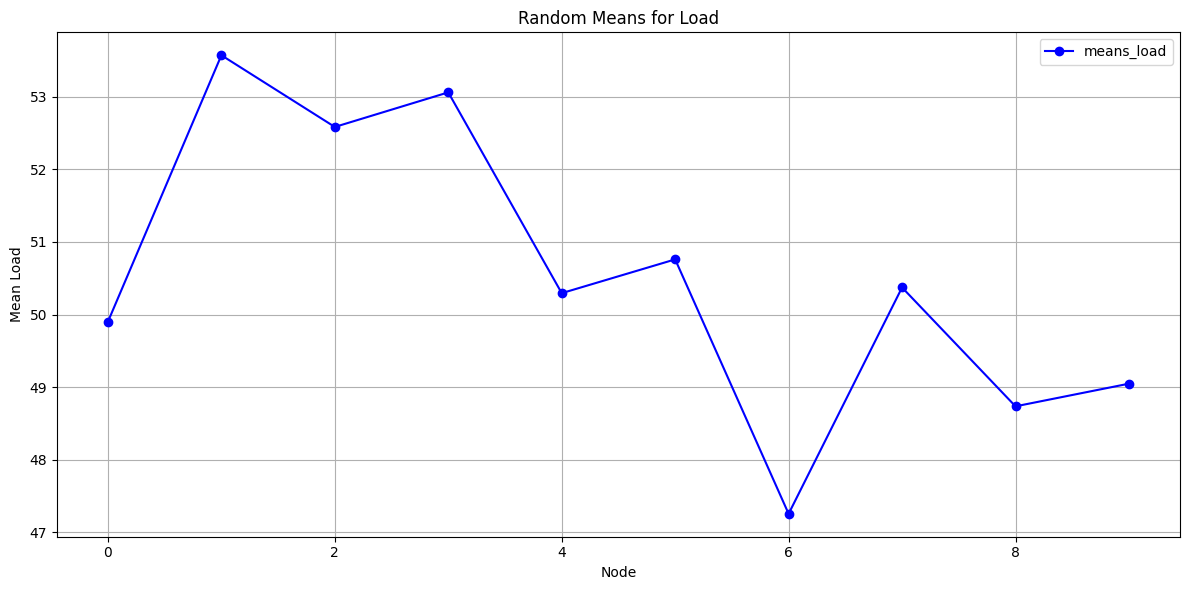

[49.90132853 53.57221467 52.58430107 53.06095432 50.29404805 50.75953581
 47.25391355 50.37251507 48.73472347 49.0468346 ]


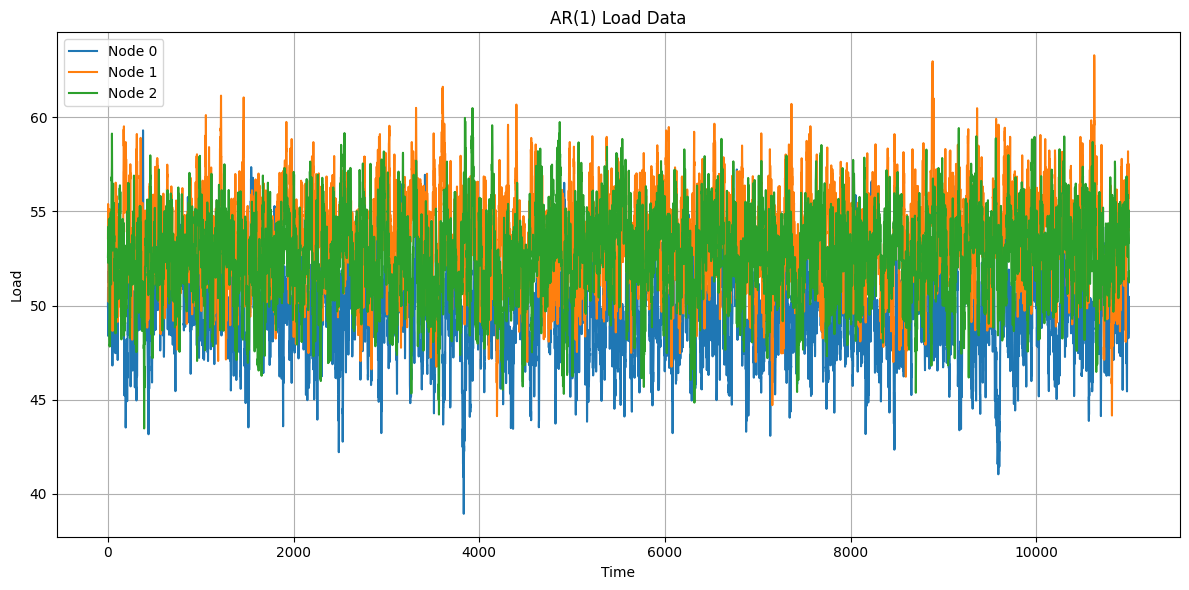

In [2]:
# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load


# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)


# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)


# 绘制指定范围内的AR(1)数据
def plot_ar1_data(load_data, start, end):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title('AR(1) Load Data')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


N = 10
T_train = 10000
T_test = 1000
T = T_train + T_test
mean_load = 50
var_load = 10

means_load = generate_means(N, mean_load, var_load)
print(means_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

# Generate AR(1) data
theta = 0.9
load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
# Plotting AR(1) data
plot_ar1_data(load_ar1[:3], 0, T)

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.4.0+cu124
12.4


In [4]:
import torch_geometric

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader

# 假设load_ar是你提供的10*11000的负载数据
N = 10
T_train = 10000
T_test = 1000
load_ar = load_ar1


In [ ]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        self.sequences = self.create_sequences(data, seq_length)

    def create_sequences(self, data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            sequence = data[i:i + seq_length]
            sequences.append(sequence)
        return torch.stack(sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.data[idx + self.seq_length]

# 假设你的输入数据形状为 [T_train, N]
train_x = torch.randn(10000, 10)  # Example data
seq_length = 20
dataset = TimeSeriesDataset(train_x, seq_length)

In [6]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, seq_length=20):
        super(GNNModel, self).__init__()
        self.seq_length = seq_length
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
        self.fc = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes = x.size()

        # Apply GCNConv to each time step individually
        x = x.view(-1, num_nodes)  # Shape becomes [batch_size * seq_len, num_nodes]
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = x.view(batch_size, seq_len, num_nodes)  # Reshape back to [batch_size, seq_len, num_nodes]

        # Pass the transformed features through GRU
        out, _ = self.rnn(x)

        # Use the last time step's output to predict the next time step's node values
        out = self.fc(out[:, -1, :])  # Shape [batch_size, num_nodes]
        return out

数据切分的讨论
1. 在模型输入时切分数据
将数据在模型输入时切分（即在 forward 方法之前进行切分）有以下优点：

提前聚焦：模型可以专注于处理短期时间序列，这通常对捕捉局部趋势或模式非常有利。
简化建模：整个模型在处理时具有一致的输入形状和时间范围，简化了模型设计和调试。
减少计算量：提前切分数据减少了 GRU 处理的序列长度，从而降低了计算量。
2. 在 conv2 和 rnn 之间切分数据
在 conv2 和 rnn 之间切分数据也有一些潜在的优势：

特征提取后聚焦：在特征提取（通过 conv1 和 conv2）后进行时间切分，可能会保留更多的局部时间模式信息，这些信息可以更有效地传递给 GRU 进行短期趋势预测。
灵活性：这种方法允许你在时间序列的不同阶段应用不同的处理逻辑。例如，你可以在 GCN 部分进行全局图结构特征提取，而在 GRU 部分进行局部时间序列处理。
3. 推荐方法
在模型输入时切分数据：这是更常见的做法。它确保了模型在整个处理过程中关注于短期趋势，并且通常具有更高的计算效率和更容易的调试过程。
在 conv2 和 rnn 之间切分数据：这种方法适合更复杂的场景，尤其是在你希望从全局和局部时间序列中提取不同层次的信息时。

In [7]:
# 假设一个简单的完全图结构（每个节点都与其他节点相连）
edge_index = torch.tensor(np.array([(i, j) for i in range(N) for j in range(N)]).T, dtype=torch.long)

# 准备训练数据和测试数据
train_x = torch.tensor(load_ar[:, :T_train].T, dtype=torch.float)  # (10000, 10)
test_x = torch.tensor(load_ar[:, T_train:].T, dtype=torch.float)   # (1000, 10)

# 构造Data对象
# data = Data(x=train_x, edge_index=edge_index)

# 初始化模型
model = GNNModel(in_channels=N, out_channels=N)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


In [8]:
model.train()
for epoch in range(100):  # 训练100个epoch
    optimizer.zero_grad()
    out = model(train_x, edge_index)
    loss = criterion(out, train_x)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 2604.999755859375
Epoch 2, Loss: 2589.670654296875
Epoch 3, Loss: 2570.376708984375
Epoch 4, Loss: 2564.61376953125
Epoch 5, Loss: 2564.3896484375
Epoch 6, Loss: 2564.36181640625
Epoch 7, Loss: 2564.279052734375
Epoch 8, Loss: 2563.746826171875
Epoch 9, Loss: 2558.594482421875
Epoch 10, Loss: 2547.6650390625
Epoch 11, Loss: 2544.3408203125
Epoch 12, Loss: 2544.24169921875
Epoch 13, Loss: 2544.239990234375
Epoch 14, Loss: 2544.239990234375
Epoch 15, Loss: 2544.239990234375
Epoch 16, Loss: 2544.239990234375
Epoch 17, Loss: 2544.239990234375
Epoch 18, Loss: 2544.239990234375
Epoch 19, Loss: 2544.239990234375
Epoch 20, Loss: 2544.239990234375
Epoch 21, Loss: 2544.239990234375
Epoch 22, Loss: 2544.239990234375
Epoch 23, Loss: 2544.239990234375
Epoch 24, Loss: 2544.239990234375
Epoch 25, Loss: 2544.239990234375
Epoch 26, Loss: 2544.239990234375
Epoch 27, Loss: 2544.239990234375
Epoch 28, Loss: 2544.239990234375
Epoch 29, Loss: 2544.239990234375
Epoch 30, Loss: 2544.23999023437

In [9]:
model.eval()
predictions_list = []
real_values_list = []

for t in range(T_test):
    with torch.no_grad():
        # 当前时间步的真实数据（还未观测）
        current_test_x = test_x[t:t+1, :].unsqueeze(0)  # 形状调整为 [1, 1, N]
        
        
        # 使用模型对下一个时间步进行预测
        predicted_x = model(train_x[:, :], edge_index)  # 调整输入形状为 [1, 1, N]

        predictions_list.append(predicted_x.squeeze().numpy())

        # 获取真实数据（模拟在线过程）
        real_x = current_test_x.numpy().squeeze(0)  # 恢复原始形状 [1, N]
        real_values_list.append(real_x.squeeze())

        # 计算损失并使用真实数据微调模型
        loss = criterion(predicted_x.squeeze(0), current_test_x.squeeze(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新历史数据（加入新观测到的真实数据）
        train_x = torch.cat([train_x, current_test_x.squeeze(0)], dim=0)  # 将当前时间步的真实数据加入历史数据


RuntimeError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# 将预测值和真实值转换为NumPy数组
predictions_np = np.array(predictions_list)
real_values_np = np.array(real_values_list)

# 选择某个节点，比如节点0，绘制真实值与预测值的对比图
node_index = 0
plt.figure(figsize=(15, 5))
plt.plot(real_values_np[:, node_index], label='Real', linewidth=2)
plt.plot(predictions_np[:, node_index], label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Node {node_index} Real vs Predicted Load over Time')
plt.xlabel('Time step')
plt.ylabel('Load value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 计算后1000次的平均MSE
mse = np.mean((predictions_np - real_values_np) ** 2, axis=0)
print(f'Overall MSE for last 1000 time steps: {mse}')
